# Comparación de PHL con otros métodos de selección de instancias

In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt


dbpath = '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx'
target = 'Class'


SEED = 2025
np.random.seed(SEED)

PROFILING = True # False para tomar todo el dataset, True para tomar una muestra para hacer pruebas rápidas
results_folder = '../results/drybeans_new/' if not PROFILING else '../results/drybeans_new_profiling/'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [2]:
df = pd.read_excel(dbpath, )

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (13611, 17)


Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   13611.000000  13611.000000     13611.000000     13611.000000   
mean    53048.284549    855.283459       320.141867       202.270714   
std     29324.095717    214.289696        85.694186        44.970091   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36328.000000    703.523500       253.303633       175.848170   
50%     44652.000000    794.941000       296.883367       192.431733   
75%     61332.000000    977.213000       376.495012       217.031741   
max    254616.000000   1985.370000       738.860153       460.198497   

       AspectRation  Eccentricity     ConvexArea  EquivDiameter        Extent  \
count  13611.000000  13611.000000   13611.000000   13611.000000  13611.000000   
mean       1.583242      0.750895   53768.200206     253.064220      0.749733   
std        0.246678      0.092002   29774.915817      59.177120      0.049086   
min        1.024868      0.218951   20684.000000     161.243764      0.555315   
25%        1.432307      0.715928   36714.500000     215.068003      0.718634   
50%        1.551124      0.764441   45178.000000     238.438026      0.759859   
75%        1.707109      0.810466   62294.000000     279.446467      0.786851   
max        2.430306      0.911423  263261.000000     569.374358      0.866195   

           Solidity     roundness   Compactness  ShapeFactor1  ShapeFactor2  \
count  13611.000000  13611.000000  13611.000000  13611.000000  13611.000000   
mean       0.987143      0.873282      0.799864      0.006564      0.001716   
std        0.004660      0.059520      0.061713      0.001128      0.000596   
min        0.919246      0.489618      0.640577      0.002778      0.000564   
25%        0.985670      0.832096      0.762469      0.005900      0.001154   
50%        0.988283      0.883157      0.801277      0.006645      0.001694   
75%        0.990013      0.916869      0.834270      0.007271      0.002170   
max        0.994677      0.990685      0.987303      0.010451      0.003665   

       ShapeFactor3  ShapeFactor4  
count  13611.000000  13611.000000  
mean       0.643590      0.995063  
std        0.098996      0.004366  
min        0.410339      0.947687  
25%        0.581359      0.993703  
50%        0.642044      0.996386  
75%        0.696006      0.997883  
max        0.974767      0.999733

In [3]:
df.head()

Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER  
1     0.953861      0.006979      0.003564      0.909851      0.998430  SEKER  
2     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER  
3     0.928329      0.007017      0.003215      0.861794      0.994199  SEKER  
4     0.970516      0.006697      0.003665      0.941900      0.999166  SEKER

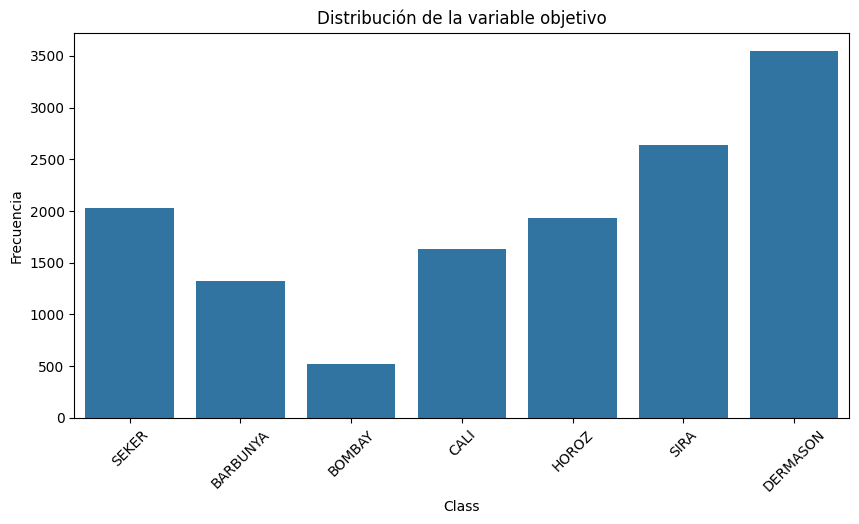

In [4]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [5]:
if PROFILING:
    df = df.sample(1000, random_state=SEED)

In [6]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

In [7]:
# Modelos ML
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=2025)
xgb = XGBClassifier(n_estimators=100, random_state=2025)

In [8]:
"""
# import pipeline
knn_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', knn)
])

rf_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf)
])

xgb_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb)
])
"""

"\n# import pipeline\nknn_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', knn)\n])\n\nrf_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', rf)\n])\n\nxgb_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', xgb)\n])\n"

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
def reduce(X,y,perc,method):
    if method == 'SRS':
        X_red, y_red = srs_selection(X,y,perc)
    if method == 'CLC':
        X_red, y_red = clc_selection(X,y,perc)
    if method == 'PHL':
        X_red, y_red = phl_selection(X, y, 0.05, perc, 'restrictedDim', 2, 'representative')
    return X_red, y_red

models = {'KNN': knn, 'RF': rf, 'XGB': xgb}
reduction_methods = {'SRS': lambda X,y,perc: srs_selection(X,y,perc), 
                     'CLC': lambda X,y,perc: clc_selection(X,y,perc), 
                     'PHL': lambda X,y,perc: phl_selection(X,y,perc=perc, topological_radius=0.05, scoring_version='restrictedDim', dimension=1, landmark_type='representative')}

reduction_methods_without_perc = {'CNN': lambda X,y: cnn_selection(X,y), 
                                'DROP3': lambda X,y: drop3_selection(X,y)}

all_reduction_methods = reduction_methods | reduction_methods_without_perc

percentages = [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]
metrics = ['reduction_ratio', 'representativeness', 'accuracy', 'f1', 'training_time', 'reduction_time']

## Test de hiperparámetros de PHL

In [11]:
phl_results = pd.DataFrame(columns=['model', 'reduction_method', 'percentage', 'delta'] + metrics)
deltas = [0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5]
modes = ['representative', 'vital'] # if not PROFILING else ['representative']
dimensions = [(1, 'restrictedDim'), (2, 'multiDim'), (0, 'restrictedDim')] # if not PROFILING else [(1, 'restrictedDim')]

if os.path.exists(results_folder + '/phl_results.csv'):
    phl_results = pd.read_csv(results_folder + '/phl_results.csv')
else:
    for model_name in models.keys():
        for mode in modes:
            for dimension, scoring_version in dimensions:
                for percentage in percentages:
                    for delta in deltas:
                        # Reduce the dataset
                        t0 = time.time()
                        X_red, y_red = phl_selection(X_train_scaled, y_train, delta, percentage, scoring_version, dimension, mode)
                        reduction_time = time.time() - t0

                        # Fit the model
                        t0 = time.time()
                        model = models[model_name]
                        model.fit(X_red, y_red)
                        training_time = time.time() - t0

                        # Evaluate the model
                        y_pred_test = model.predict(X_test_scaled)
                        accuracy = accuracy_score(y_test, y_pred_test)
                        f1 = f1_score(y_test, y_pred_test, average='weighted')

                        # Calculate representativeness
                        epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

                        # Store the results
                        phl_results = phl_results.append({
                            'model': model_name,
                            'reduction_method': f'PHL_{mode}_{scoring_version}_{dimension}',
                            'percentage': percentage,
                            'delta': delta,
                            'reduction_ratio': len(y_red) / len(y_train),
                            'representativeness': epsilon,
                            'accuracy': accuracy,
                            'f1': f1,
                            'training_time': training_time,
                            'reduction_time': reduction_time,
                        }, ignore_index=True)
    # Save the results
    phl_results.to_csv(f'{results_folder}/phl_results.csv', index=False)

In [12]:
phl_results

model                    reduction_method  percentage  delta  \
0     KNN  PHL_representative_restrictedDim_1        0.05   0.02   
1     KNN  PHL_representative_restrictedDim_1        0.05   0.05   
2     KNN  PHL_representative_restrictedDim_1        0.05   0.10   
3     KNN  PHL_representative_restrictedDim_1        0.05   0.20   
4     KNN  PHL_representative_restrictedDim_1        0.05   0.25   
..    ...                                 ...         ...    ...   
877   XGB           PHL_vital_restrictedDim_0        0.90   0.10   
878   XGB           PHL_vital_restrictedDim_0        0.90   0.20   
879   XGB           PHL_vital_restrictedDim_0        0.90   0.25   
880   XGB           PHL_vital_restrictedDim_0        0.90   0.30   
881   XGB           PHL_vital_restrictedDim_0        0.90   0.50   

     reduction_ratio  representativeness  accuracy        f1  training_time  \
0               0.05            4.495387     0.765  0.750765       0.000657   
1               0.05            7.728277     0.810  0.800501       0.000650   
2               0.05            6.009345     0.835  0.827154       0.000427   
3               0.05            4.431942     0.800  0.789463       0.000575   
4               0.05            5.205275     0.870  0.870398       0.000585   
..               ...                 ...       ...       ...            ...   
877             0.90            2.937519     0.940  0.940268       0.314330   
878             0.90            1.660083     0.945  0.945521       0.318485   
879             0.90            1.660083     0.940  0.940444       0.319874   
880             0.90            1.597812     0.935  0.936181       0.313365   
881             0.90            3.312493     0.945  0.945505       0.296068   

     reduction_time  
0          0.029232  
1          0.099289  
2          0.022044  
3          0.030661  
4          0.032731  
..              ...  
877        0.030269  
878        0.030216  
879        0.031112  
880        0.031137  
881        0.043355  

[882 rows x 10 columns]

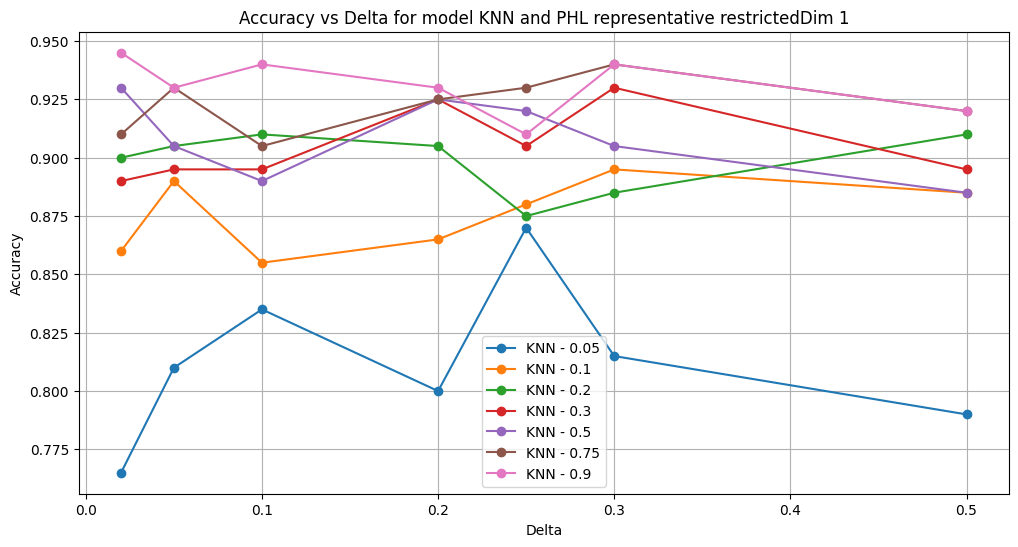

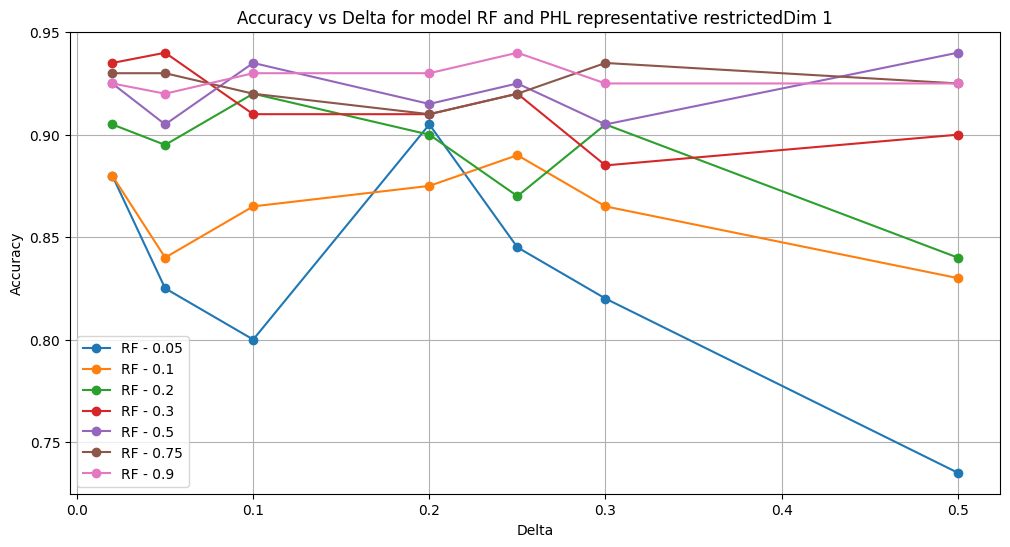

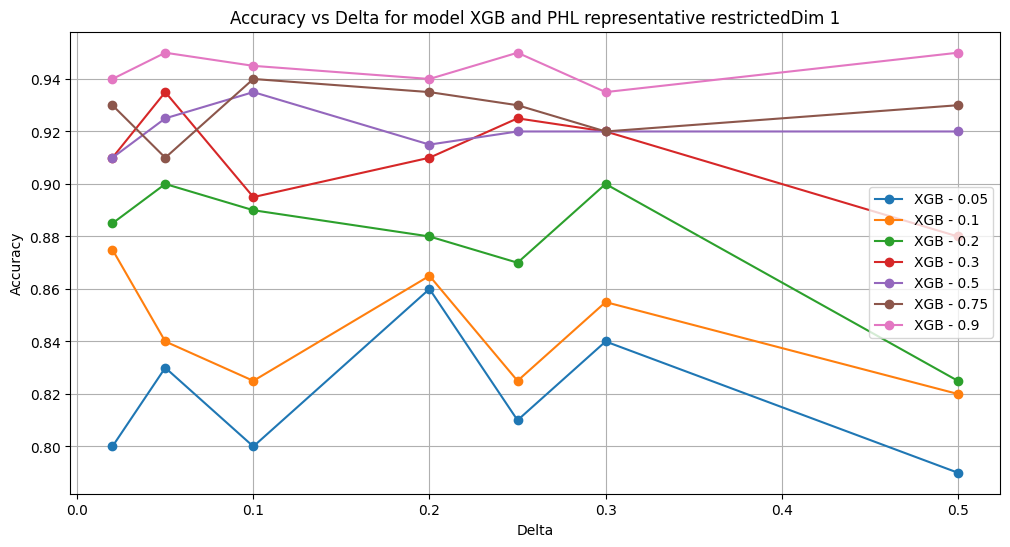

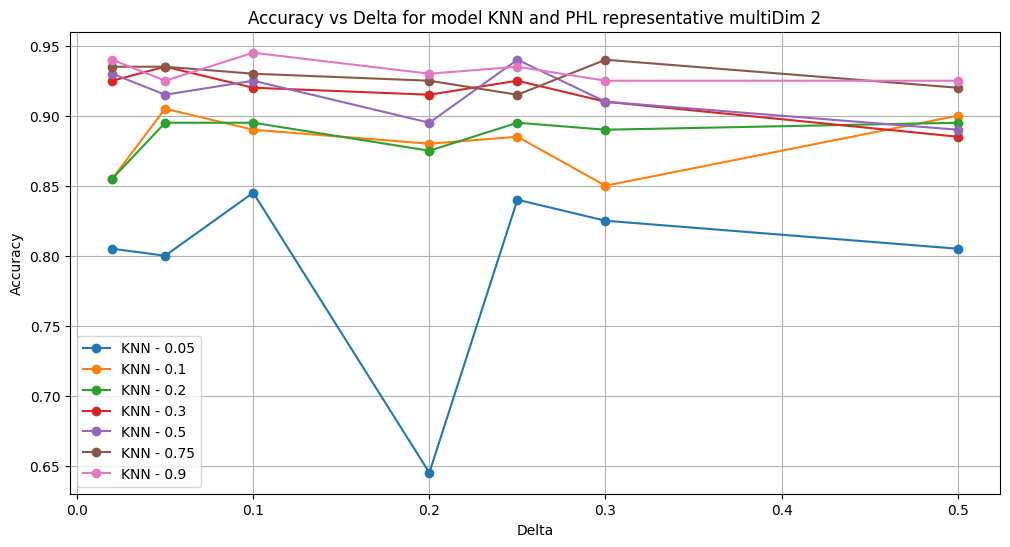

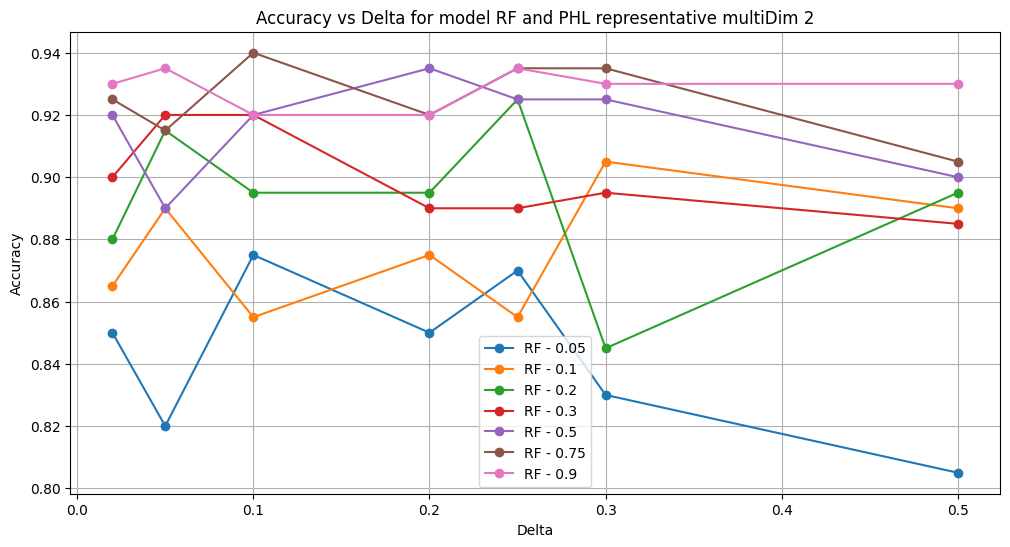

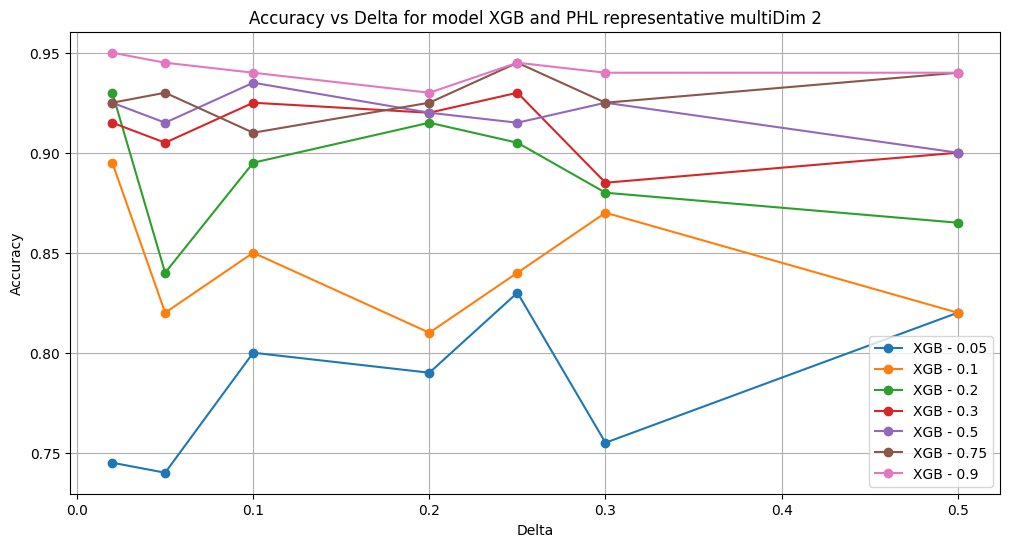

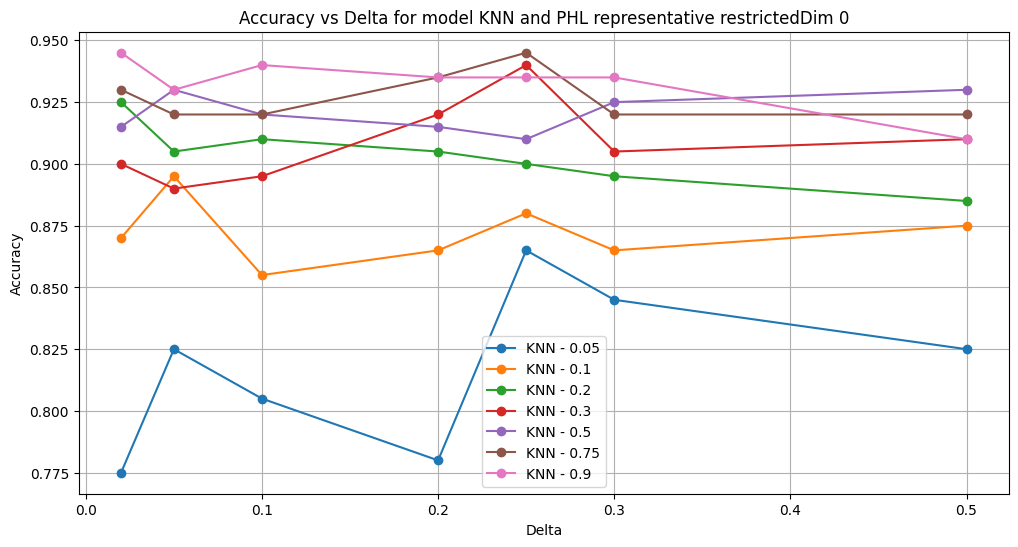

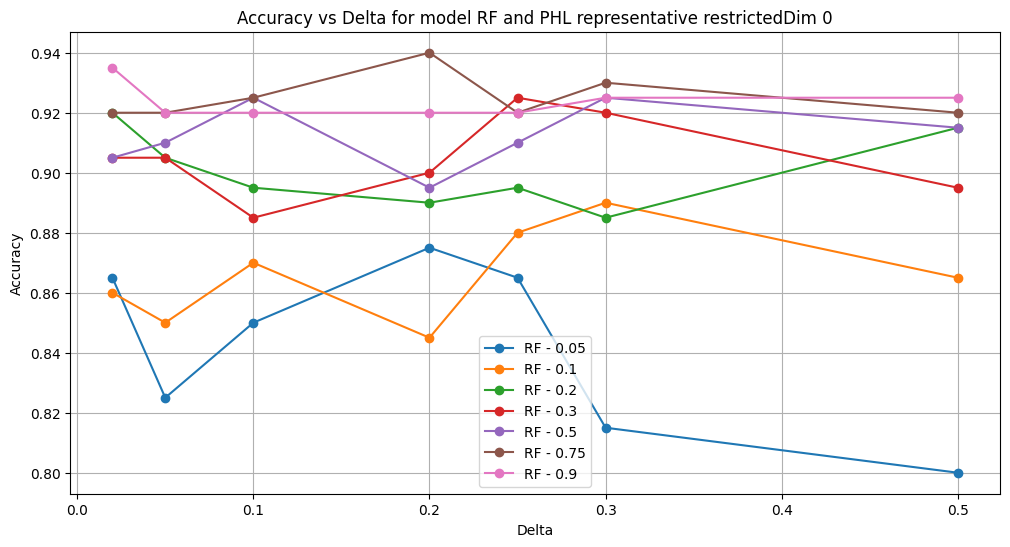

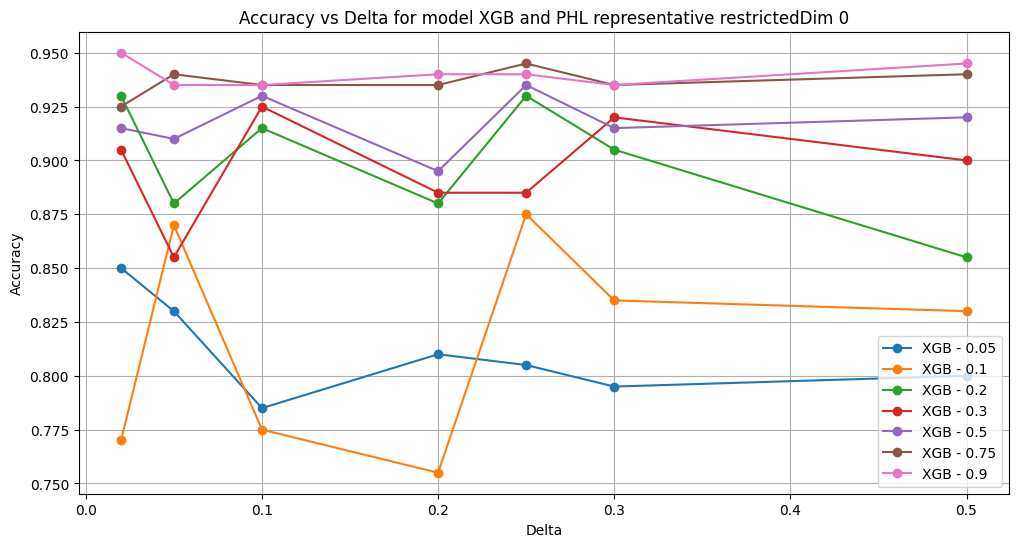

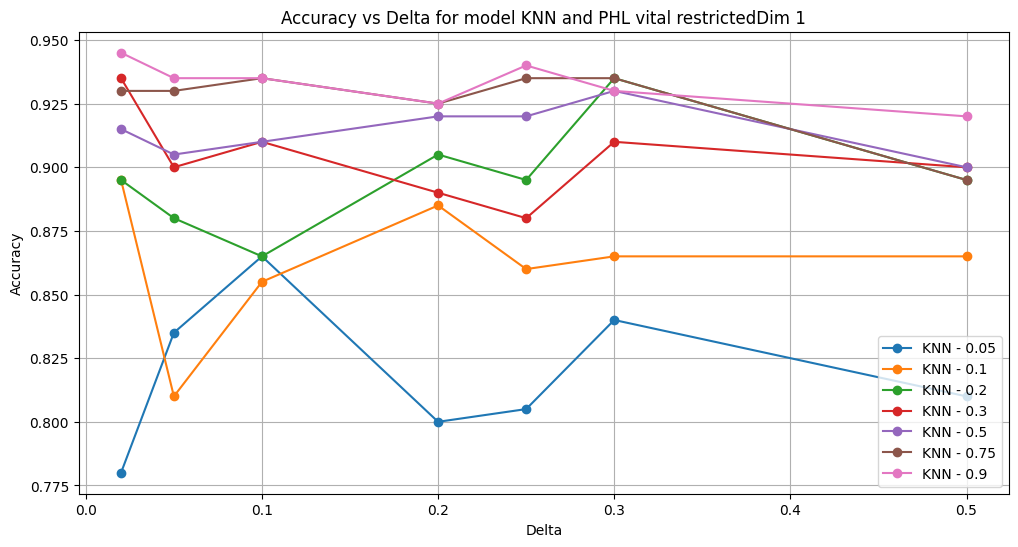

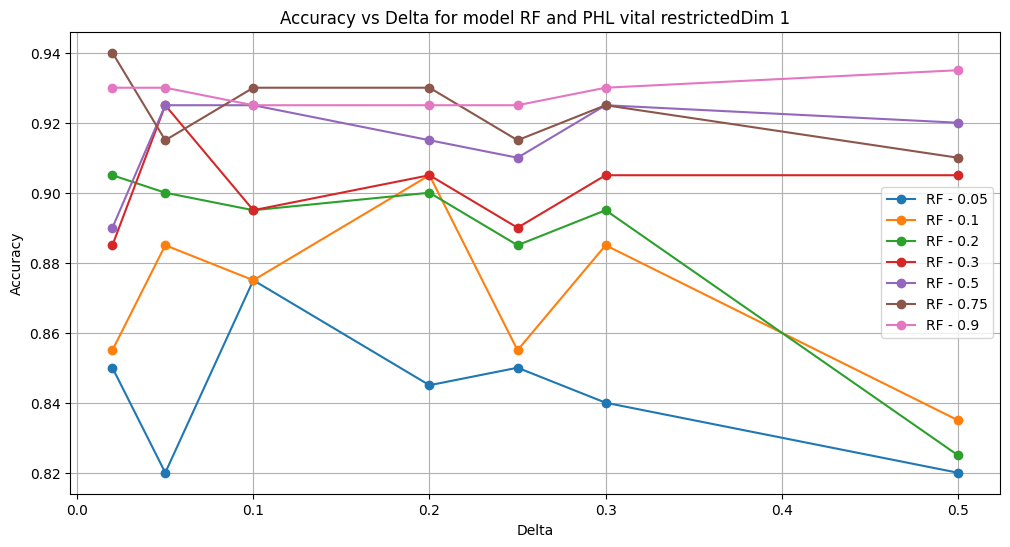

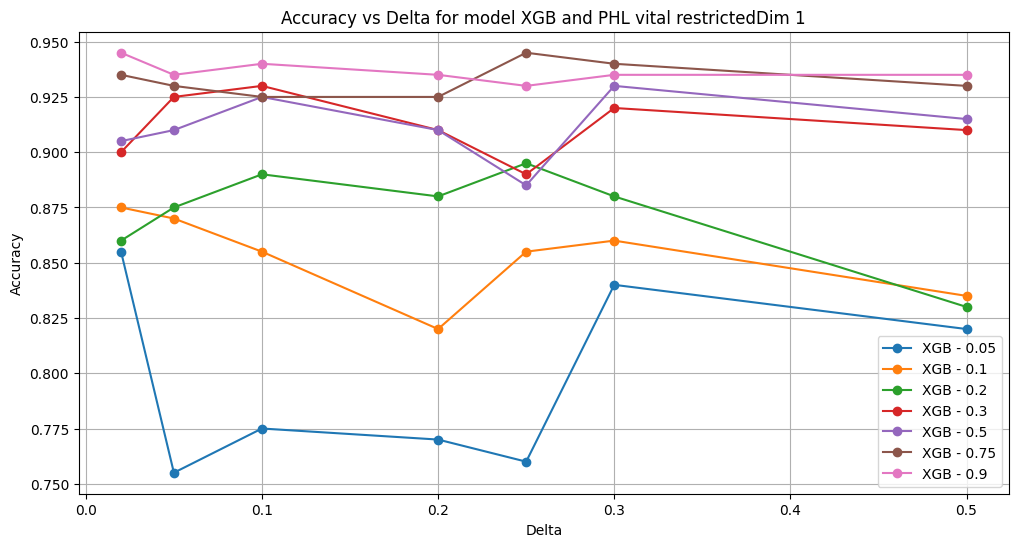

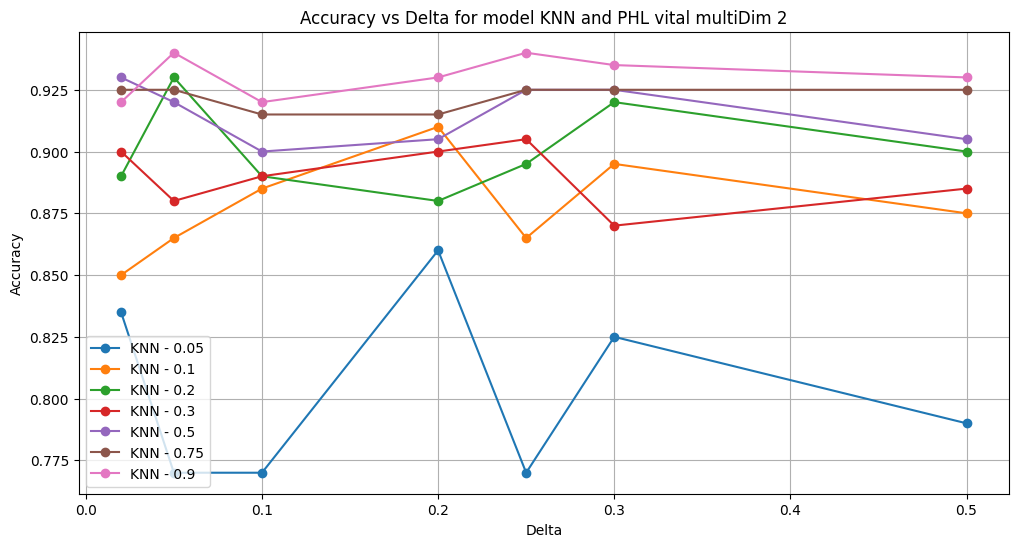

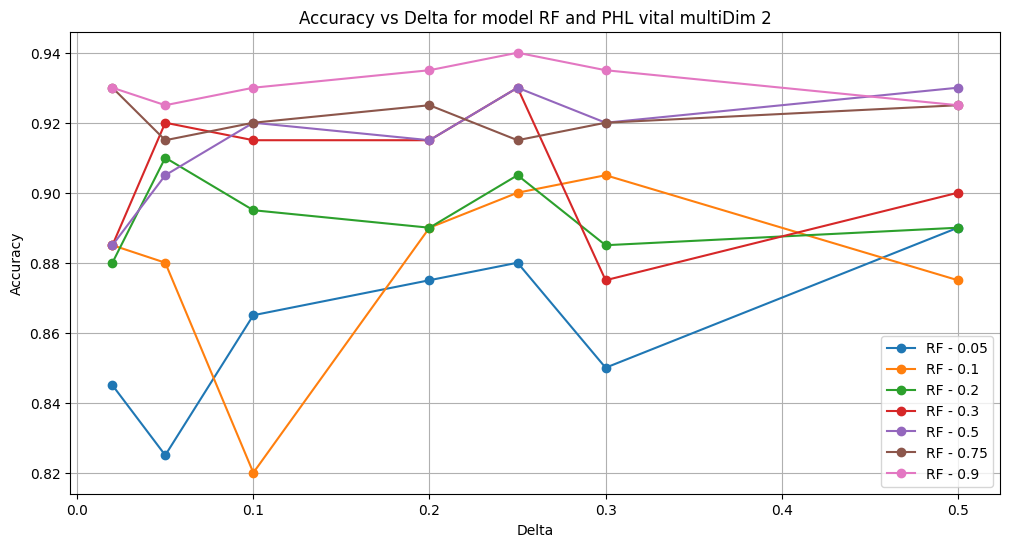

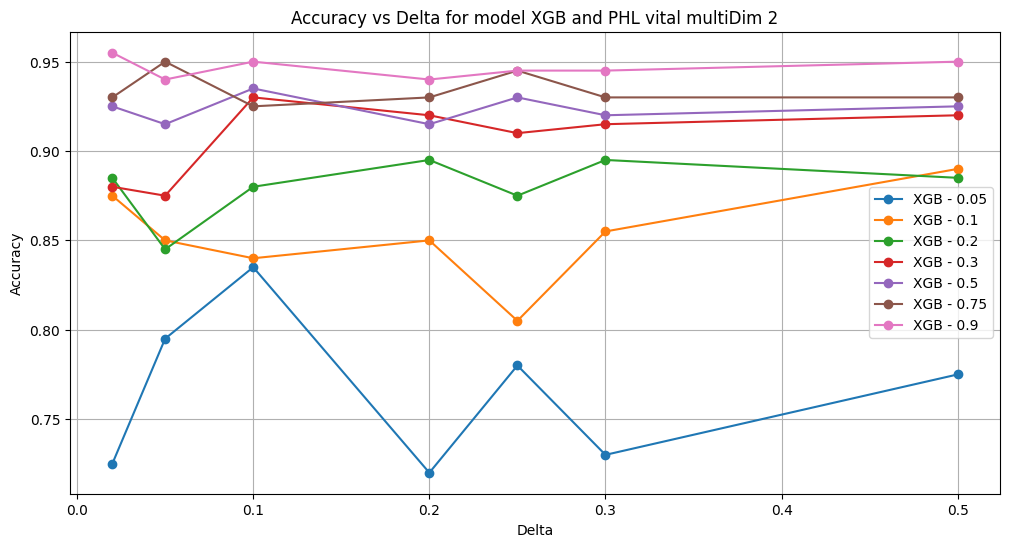

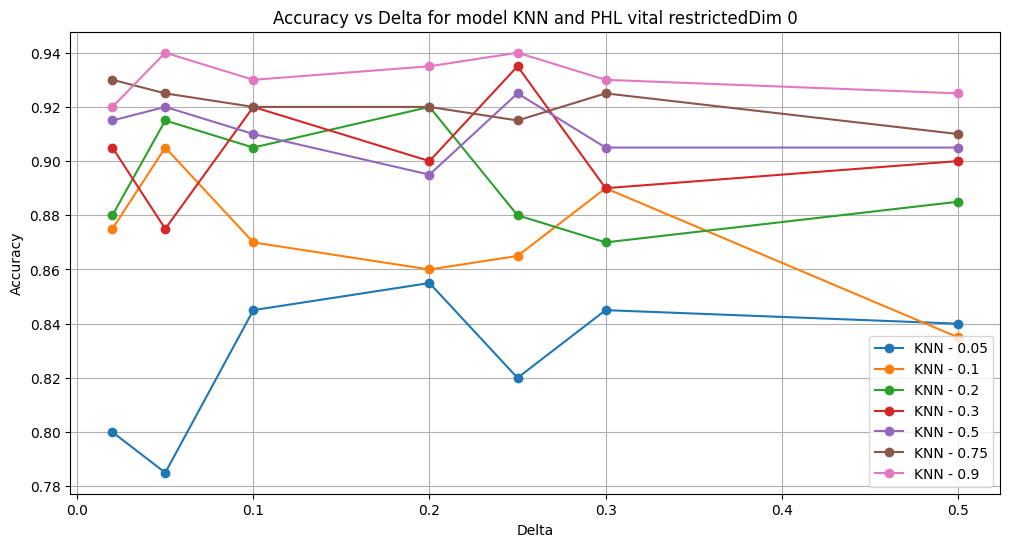

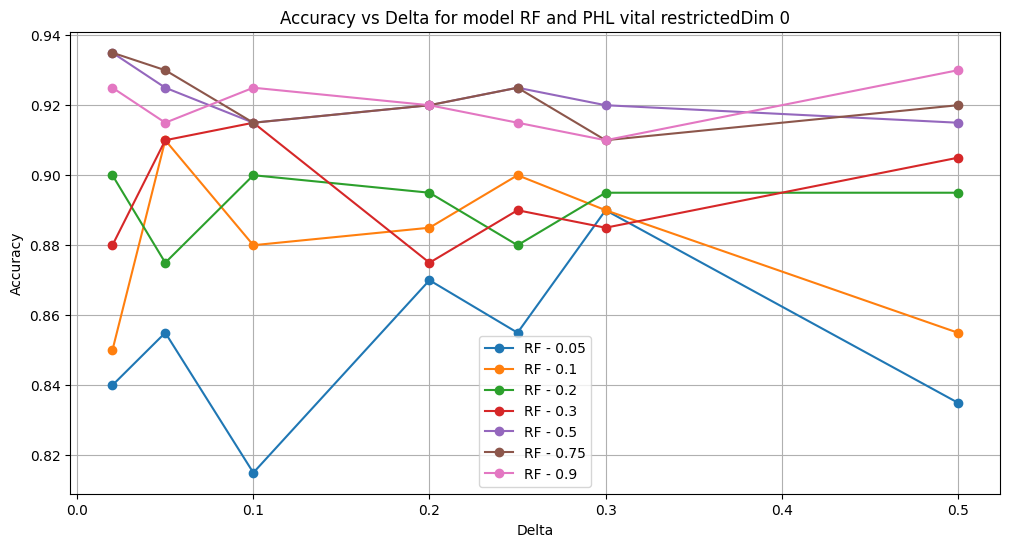

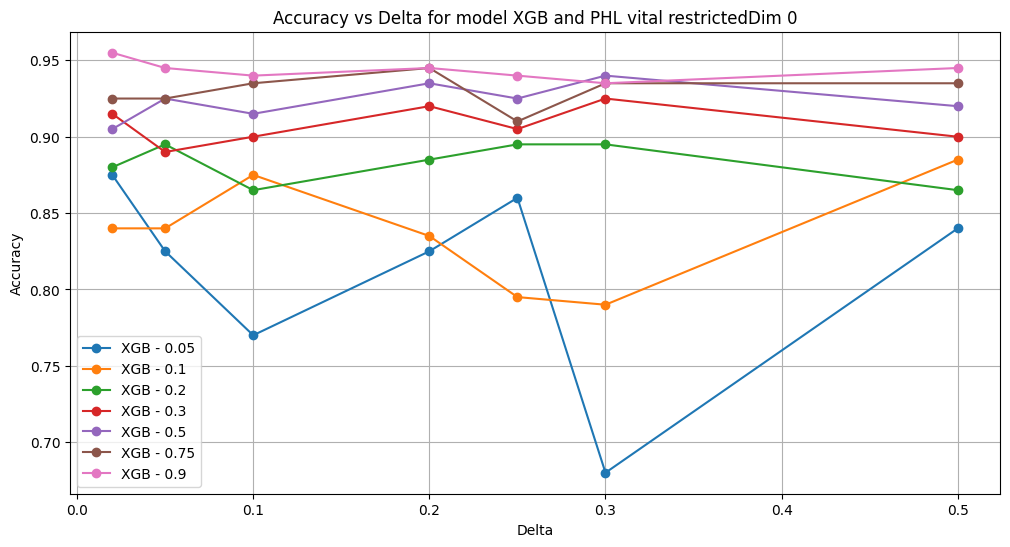

In [13]:
# Show accuracy vs delta for each model
for mode in modes:
    for dimension, scoring_version in dimensions:
        for model_name in models.keys():
            plt.figure(figsize=(12, 6))
            for percentage in percentages:
                reduction_method = f'PHL_{mode}_{scoring_version}_{dimension}'
                plt.plot(phl_results[(phl_results['model'] == model_name) & (phl_results['percentage'] == percentage) & (phl_results['reduction_method'] == reduction_method)]['delta'],
                        phl_results[(phl_results['model'] == model_name) & (phl_results['percentage'] == percentage) & (phl_results['reduction_method'] == reduction_method)]['accuracy'],
                        label=f'{model_name} - {percentage}', marker='o')
                plt.title(f'Accuracy vs Delta for model {model_name} and PHL {mode} {scoring_version} {dimension}')
                plt.xlabel('Delta')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid()
            plt.savefig(f'{results_folder}/accuracy_vs_delta_{model_name}_{mode}_{scoring_version}_{dimension}.png')
            plt.show()

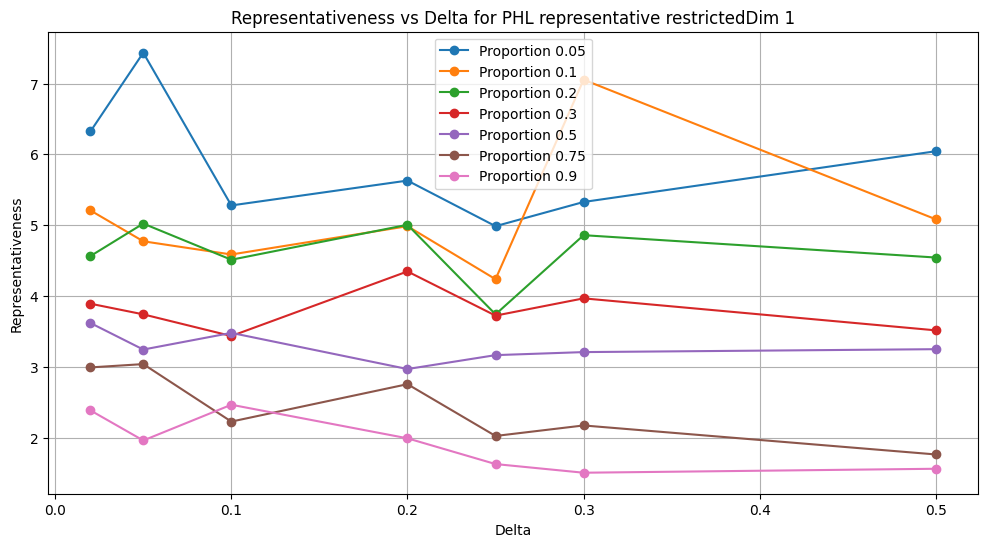

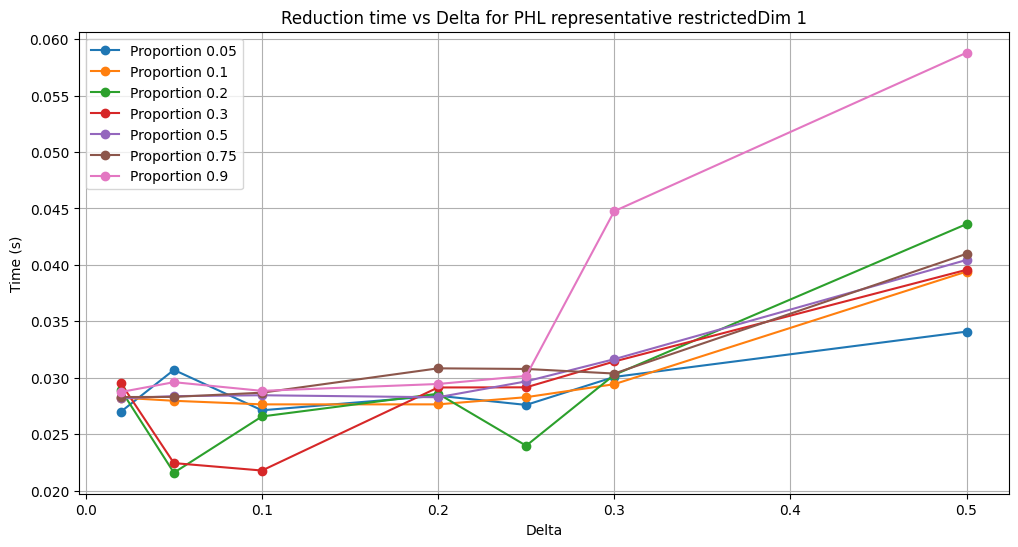

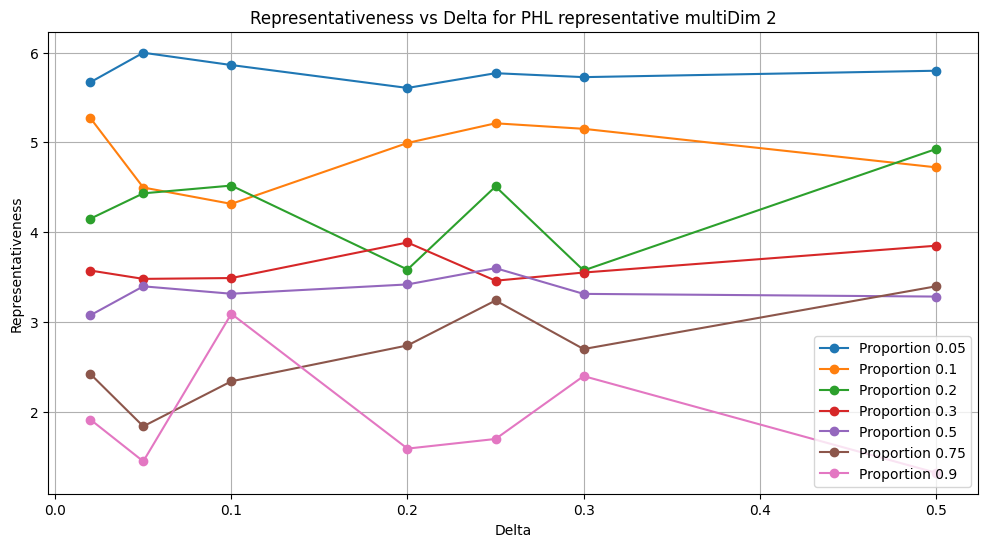

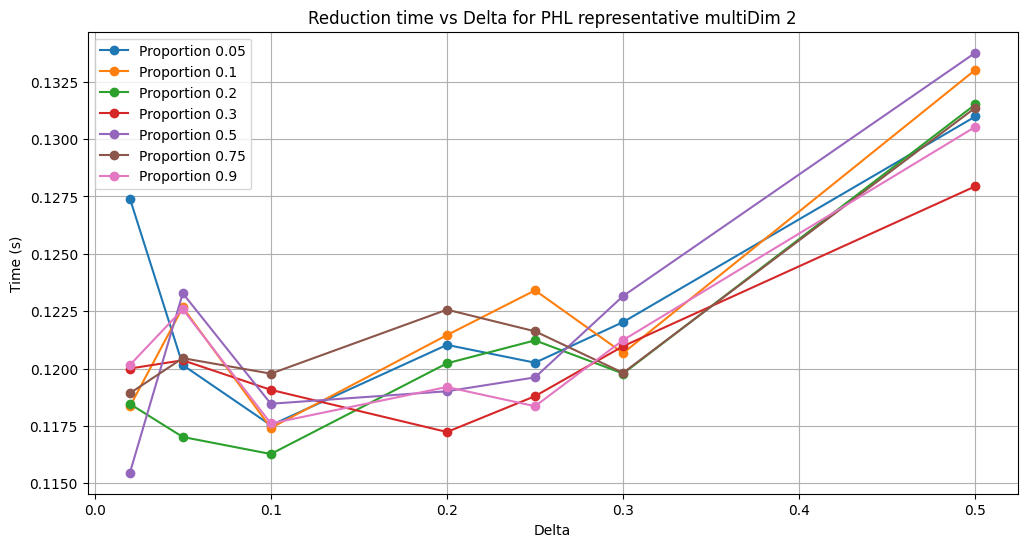

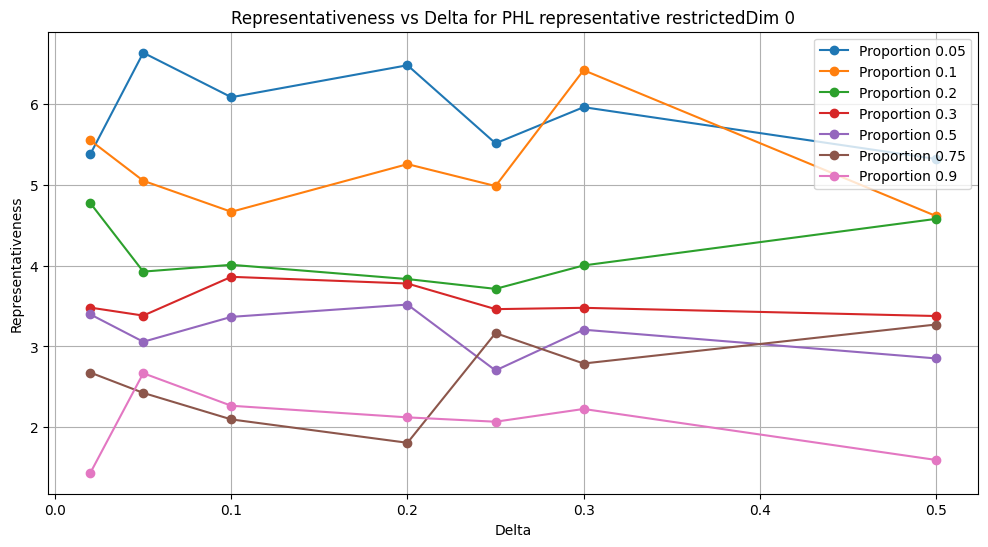

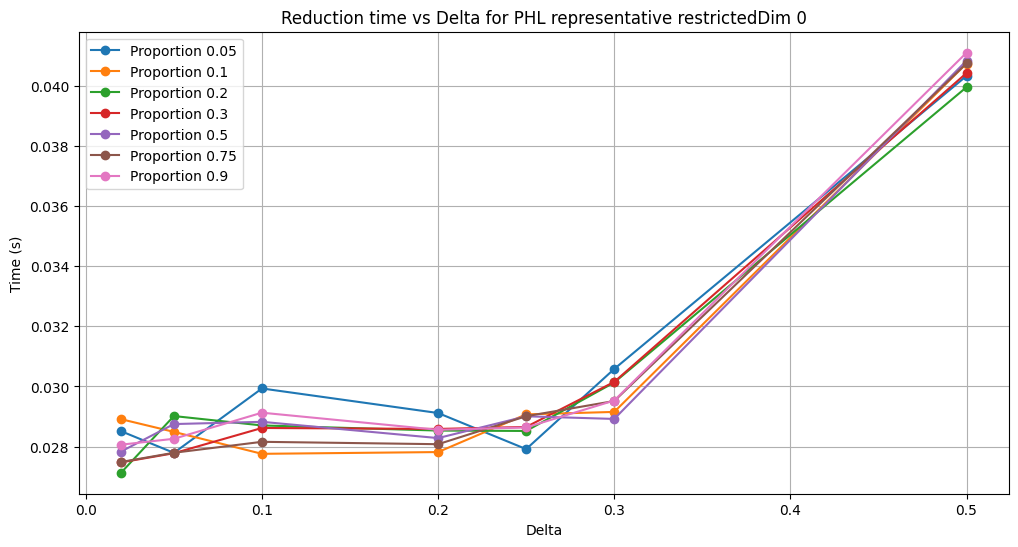

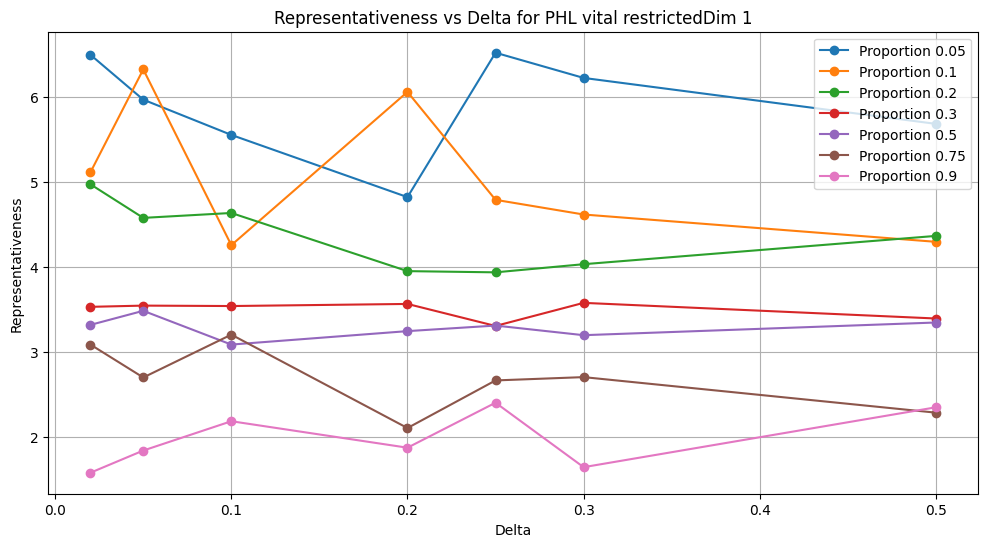

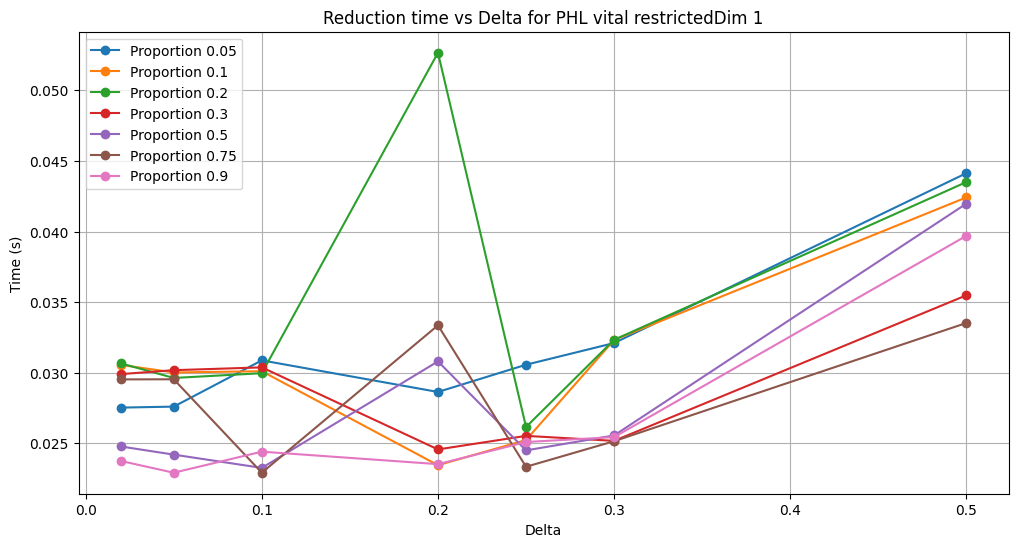

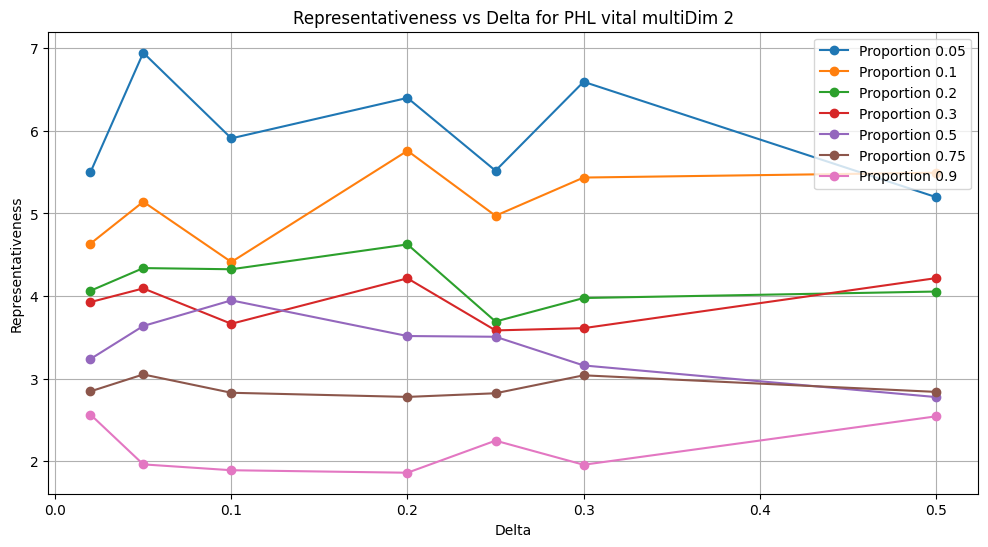

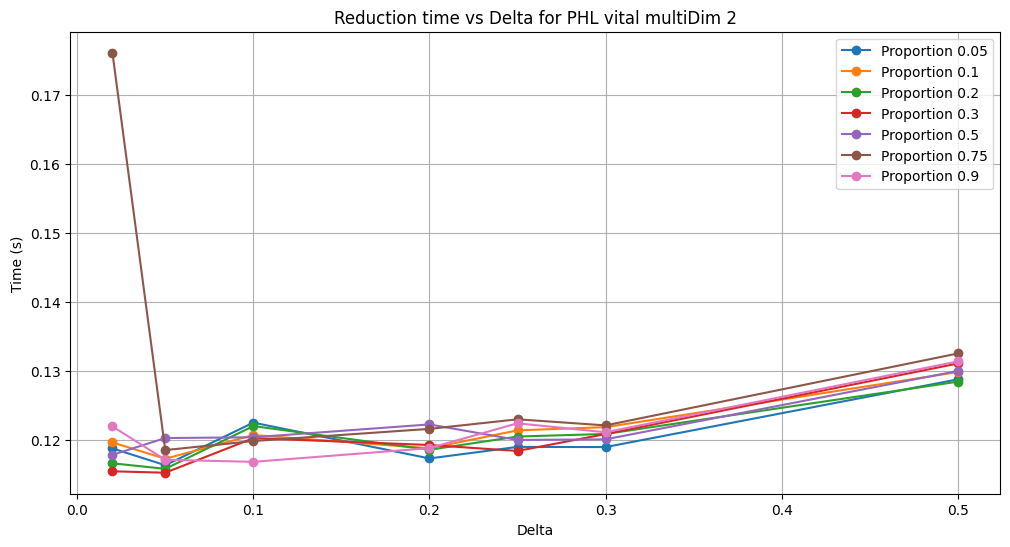

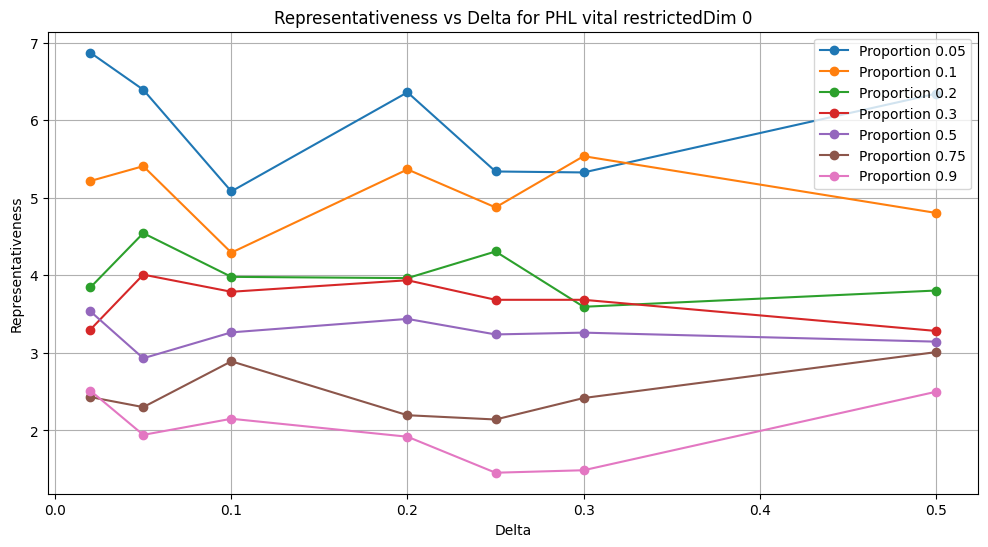

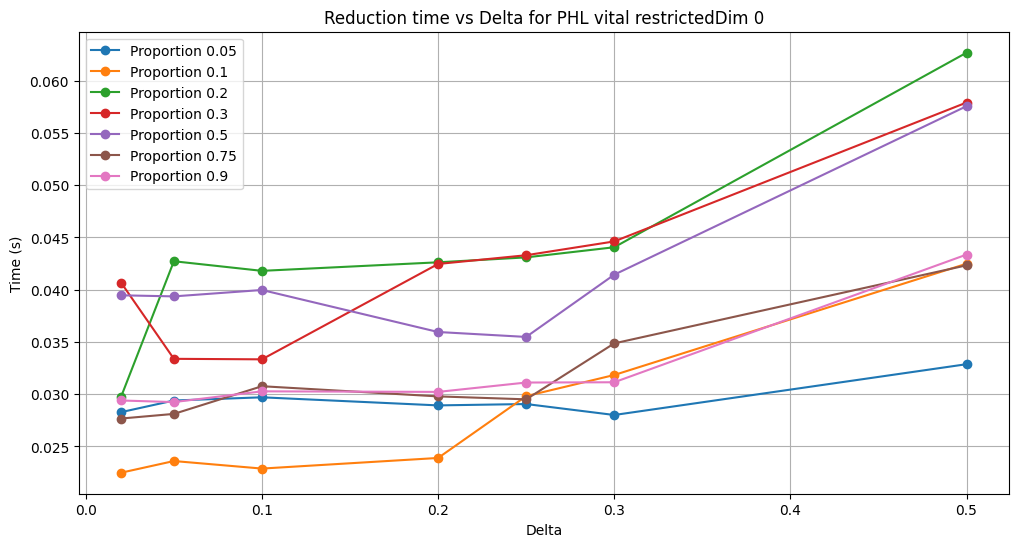

In [14]:
for mode in modes:
    for dimension, scoring_version in dimensions:
        reduction_method = f'PHL_{mode}_{scoring_version}_{dimension}'
        # Get representativeness vs delta averaged by model
        mean_representativeness_phl = phl_results[phl_results['reduction_method'] == reduction_method].groupby(['delta', 'percentage'])['representativeness'].mean().reset_index()
        # Get reduction time vs delta averaged by model
        mean_reduction_time_phl = phl_results[phl_results['reduction_method'] == reduction_method].groupby(['delta', 'percentage'])['reduction_time'].mean().reset_index()

        # Show representativeness vs delta for each percentage
        plt.figure(figsize=(12, 6))
        for percentage in percentages:
            plt.plot(mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['delta'],
                    mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['representativeness'],
                    label=f'Proportion {percentage}', marker='o')
            plt.title(f'Representativeness vs Delta for PHL {mode} {scoring_version} {dimension}')
            plt.xlabel('Delta')
            plt.ylabel('Representativeness')
            plt.legend()
            plt.grid()
        plt.savefig(f'{results_folder}/representativeness_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

        # Show time vs delta
        plt.figure(figsize=(12, 6))
        for percentage in percentages:
            plt.plot(phl_results[(phl_results['model'] == model_name) & (phl_results['percentage'] == percentage) & (phl_results['reduction_method'] == reduction_method)]['delta'],
                    phl_results[(phl_results['model'] == model_name) & (phl_results['percentage'] == percentage) & (phl_results['reduction_method'] == reduction_method)]['reduction_time'],
                        label=f'Proportion {percentage}', marker='o')
            plt.title(f'Reduction time vs Delta for PHL {mode} {scoring_version} {dimension}')
            plt.xlabel('Delta')
            plt.ylabel('Time (s)')
            plt.legend()
            plt.grid()
        plt.savefig(f'{results_folder}/reduction_time_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

## Comparación de métodos de selección de instancias

In [15]:
results = pd.DataFrame(columns=['model', 'reduction_method', 'percentage'] + metrics)
if os.path.exists(results_folder + '/results.csv'):
    results = pd.read_csv(results_folder + '/results.csv')
else:
    for model_name, model in models.items():
        # Fit the model with the full dataset
        t0 = time.time()
        model.fit(X_train_scaled, y_train)
        t = time.time() - t0

        # Evaluate the model
        y_pred_test = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        epsilon = 1
        # Store the results
        results = results.append({
            'model': model_name,
            'reduction_method': 'None',
            'percentage': 1.0,
            'reduction_ratio': 1.0,
            'representativeness': 0,
            'accuracy': accuracy,
            'f1': f1,
            'training_time': t,
            'reduction_time': 0
        }, ignore_index=True)

        # Fit the model with reduced dataset
        for reduction_method, reduce in reduction_methods.items():
            for percentage in percentages:
                # Reduce the dataset
                t0 = time.time()
                X_red, y_red = reduce(X_train_scaled, y_train, percentage)
                reduction_time = time.time() - t0
                
                # Fit the model
                t0 = time.time()
                model = models[model_name]
                model.fit(X_red, y_red)
                training_time = time.time() - t0

                # Evaluate the model
                y_pred_test = model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test, average='weighted')

                # Calculate representativeness
                epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

                # Store the results
                results = results.append({
                    'model': model_name,
                    'reduction_method': reduction_method,
                    'percentage': percentage,
                    'reduction_ratio': len(y_red) / len(y_train),
                    'representativeness': epsilon,
                    'accuracy': accuracy,
                    'f1': f1,
                    'training_time': training_time,
                    'reduction_time': reduction_time,
                }, ignore_index=True)

    # Reduce the dataset with methods that do not require percentage
    for reduction_method, reduce in reduction_methods_without_perc.items():
        # Reduce the dataset
        t0 = time.time()
        X_red, y_red = reduce(X_train_scaled, y_train)
        reduction_time = time.time() - t0

        # Fit the model
        t0 = time.time()
        model = models[model_name]
        model.fit(X_red, y_red)
        training_time = time.time() - t0

        # Evaluate the model
        y_pred_test = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        # Calculate representativeness
        epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

        # Store the results
        results = results.append({
            'model': model_name,
            'reduction_method': reduction_method,
            'percentage': 0,
            'reduction_ratio': len(y_red) / len(y_train),
            'representativeness': epsilon,
            'accuracy': accuracy,
            'f1': f1,
            'training_time': training_time,
            'reduction_time': reduction_time,
        }, ignore_index=True)
        
    # Save the results
    results.to_csv('results.csv', index=False)

/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/sklearn/

In [16]:
results

model reduction_method  percentage  reduction_ratio representativeness  \
0    KNN             None        1.00          1.00000                  0   
1    KNN              SRS        0.05          0.04500           6.990644   
2    KNN              SRS        0.10          0.09500           6.501831   
3    KNN              SRS        0.20          0.19500           3.813162   
4    KNN              SRS        0.30          0.29625           2.867671   
..   ...              ...         ...              ...                ...   
63   XGB              PHL        0.50          0.50125           2.867671   
64   XGB              PHL        0.75          0.75125            1.44942   
65   XGB              PHL        0.90          0.90000           3.561544   
66   XGB              CNN        0.00          0.02000           4.857918   
67   XGB            DROP3        0.00          0.14125           4.225312   

    accuracy        f1  training_time reduction_time  
0      0.935  0.935194       0.001098              0  
1      0.690  0.683444       0.000329       0.000896  
2      0.875  0.876073       0.000315       0.000727  
3      0.885  0.886952       0.000326       0.000727  
4      0.915  0.915920       0.000433       0.001011  
..       ...       ...            ...            ...  
63     0.915  0.915882       0.312142       0.029961  
64     0.935  0.935190       0.697389       0.028283  
65     0.950  0.950655       0.511565       0.029305  
66     0.690  0.695894       0.111202       0.028017  
67     0.850  0.848514       0.080575       1.210188  

[68 rows x 9 columns]

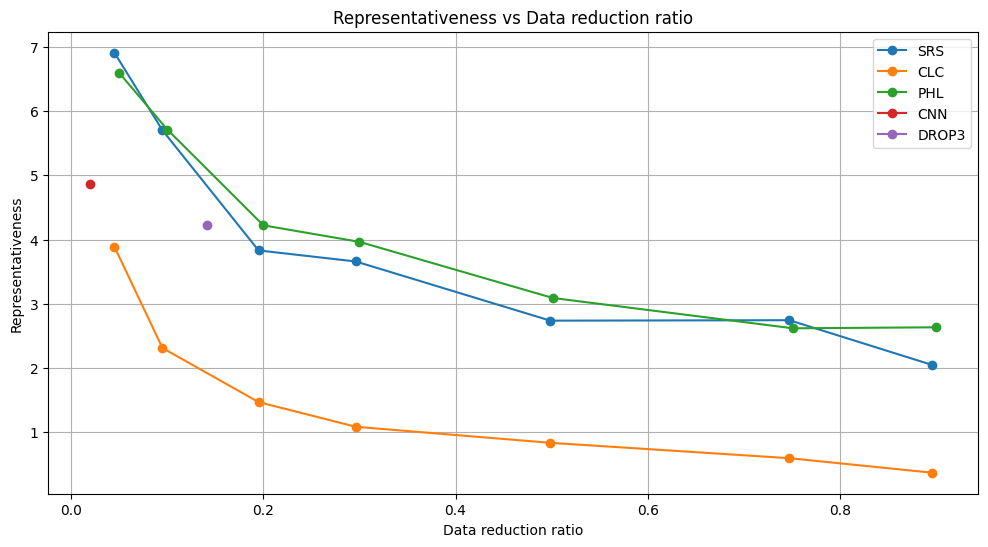

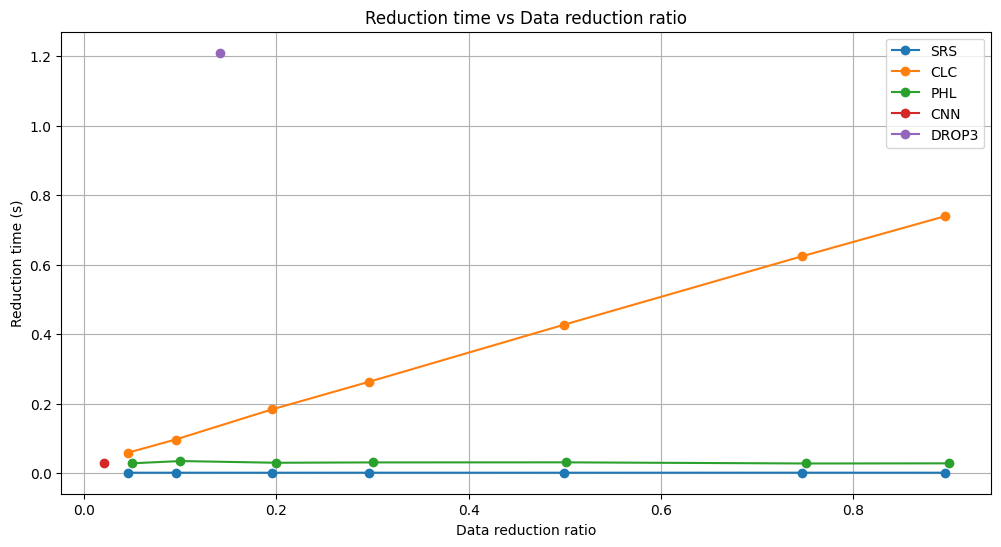

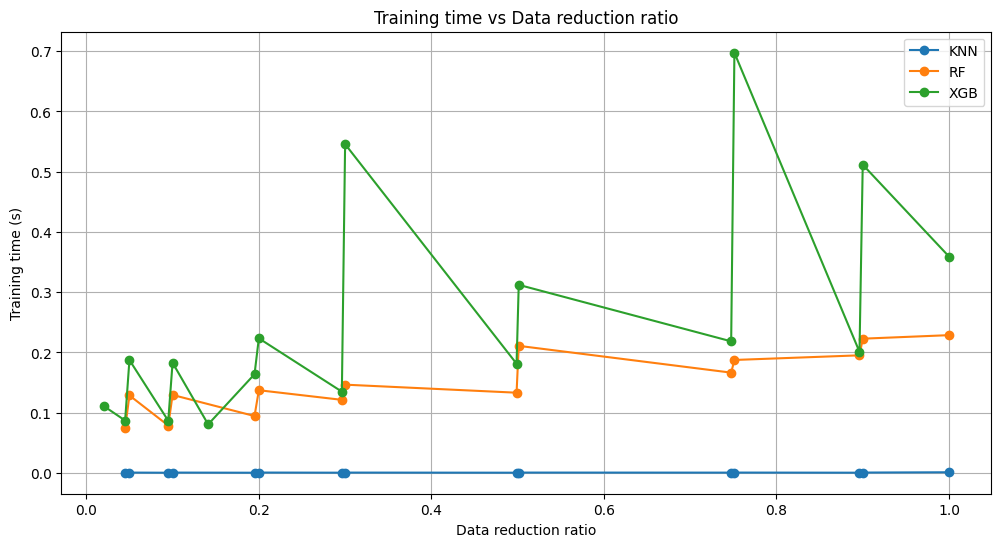

In [17]:
# Mean representativeness vs percentage averaged by model
mean_representativeness = results.groupby(['reduction_method', 'reduction_ratio'])['representativeness'].mean().reset_index()
# Mean reduction time vs percentage averaged by model
mean_reduction_time = results.groupby(['reduction_method', 'reduction_ratio'])['reduction_time'].mean().reset_index()
# Mean training time vs percentage averaged by reduction method
mean_training_time = results.groupby(['model', 'reduction_ratio'])['training_time'].mean().reset_index()

# Plot representativeness vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in all_reduction_methods:
    plt.plot(mean_representativeness[mean_representativeness['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_representativeness[mean_representativeness['reduction_method'] == reduction_method]['representativeness'],
             label=reduction_method, marker='o')
    plt.title(f'Representativeness vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Representativeness')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
plt.show()

# Plot reduction time vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in all_reduction_methods:
    plt.plot(mean_reduction_time[mean_reduction_time['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_reduction_time[mean_reduction_time['reduction_method'] == reduction_method]['reduction_time'],
             label=reduction_method, marker='o')
    plt.title(f'Reduction time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Reduction time (s)')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
plt.show()

# Plot training time vs percentage averaged by reduction method
plt.figure(figsize=(12, 6))
for model_name in models.keys():
    plt.plot(mean_training_time[mean_training_time['model'] == model_name]['reduction_ratio'],
             mean_training_time[mean_training_time['model'] == model_name]['training_time'],
             label=model_name, marker='o')
    plt.title(f'Training time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Training time (s)')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
plt.show()


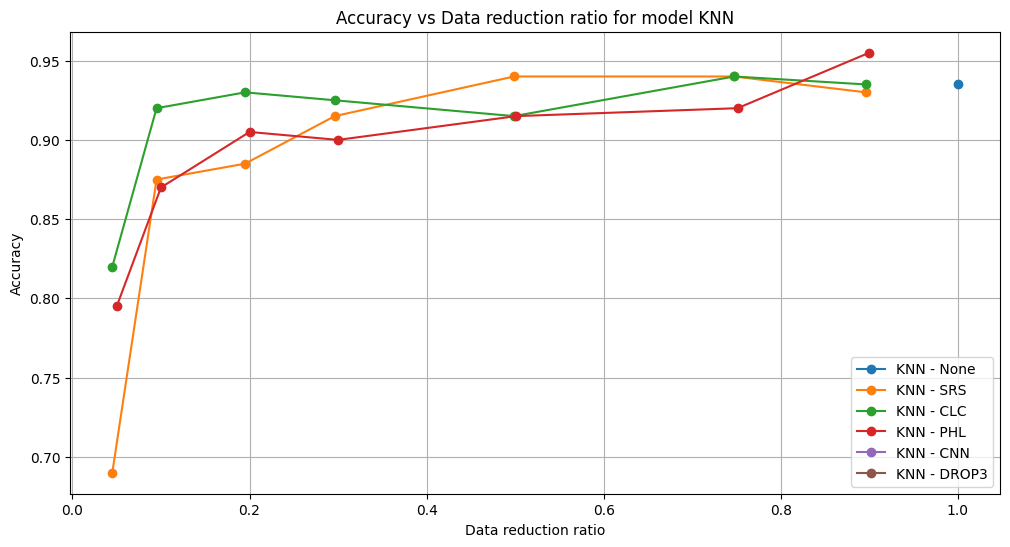

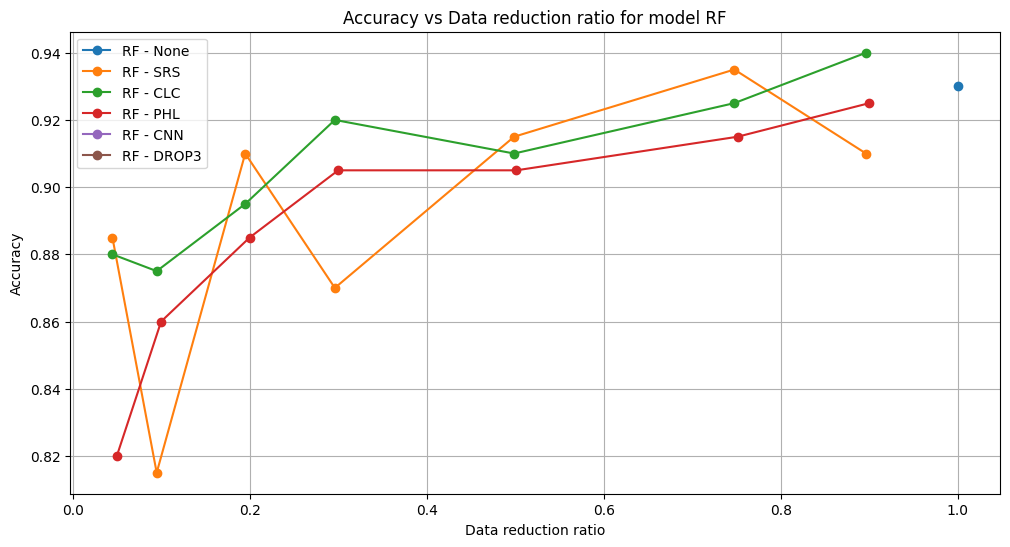

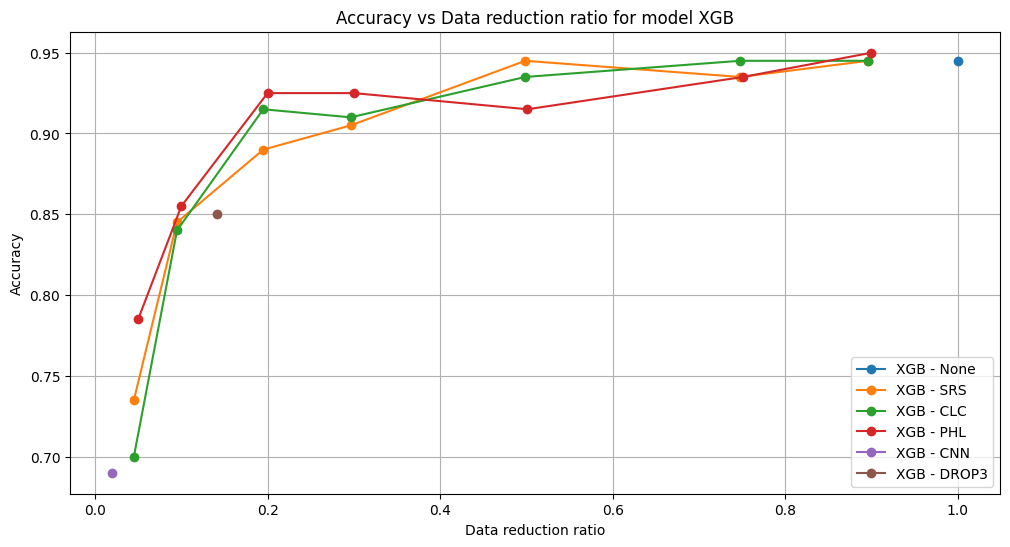

In [18]:
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['accuracy'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in all_reduction_methods:
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                 label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
    plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
    plt.show()


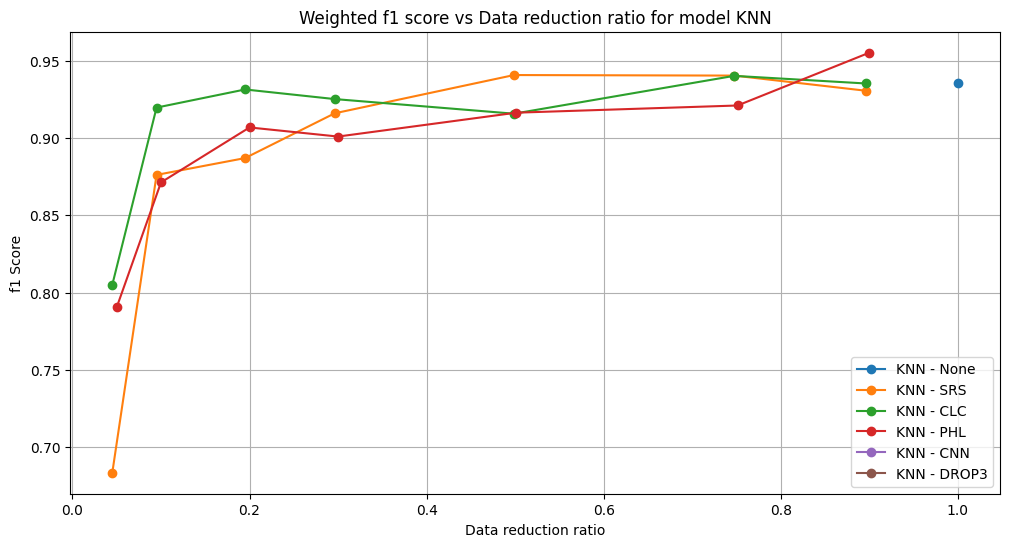

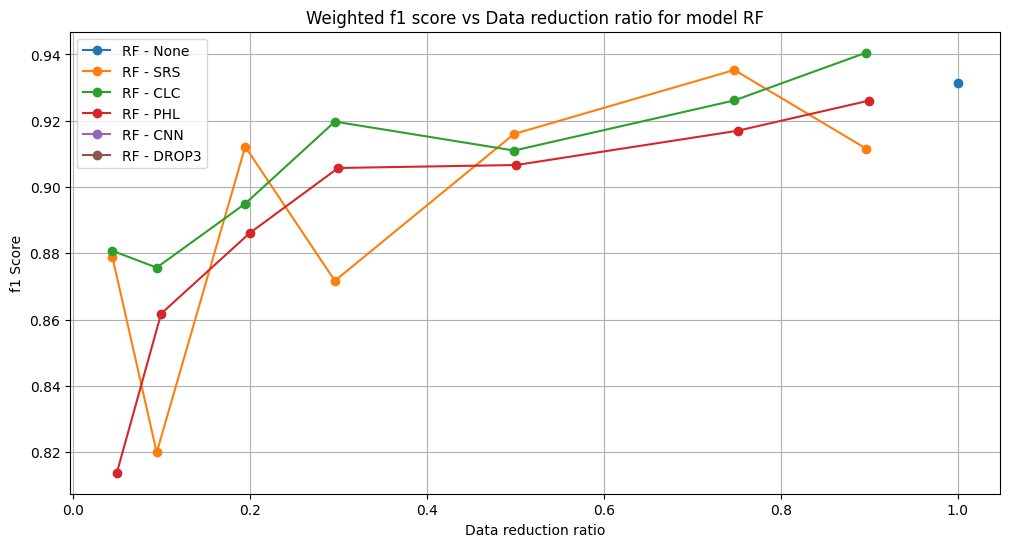

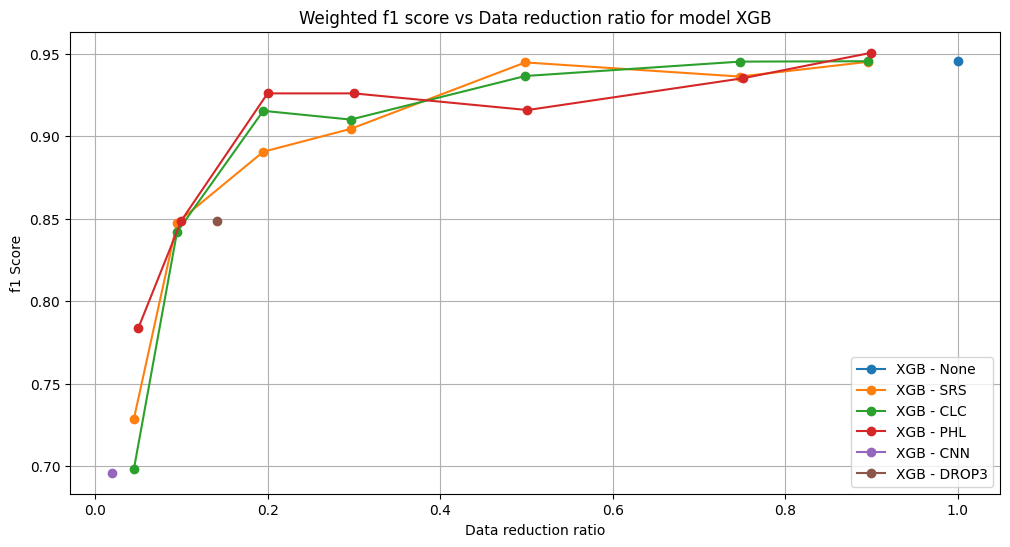

In [19]:
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['f1'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in all_reduction_methods:
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                 label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('f1 Score')
        plt.legend()
        plt.grid()
    plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
    plt.show()
